# Quantum Ising Model
Following a notebook by [Carsten Bauer & Katharine Hyatt](https://github.com/crstnbr/JuliaOulu20/blob/master/Day2/4_linear_algebra/2_ed_quantum_ising.ipynb).

The [Ising Model](https://en.wikipedia.org/wiki/Ising_model) is a model of ferromagnetism, which considers localized discrete spins of a quantum system.

We will study the Ising model in terms of the time-independent Schrödinger equation
$$
H \left|{ \psi }\right\rangle = E \left|{ \psi }\right\rangle,
$$

where $H$ is to be diagonalized by means of a computational model.

## Transverse field Ising chain
We consider the general Ising hamiltonian function

$$
\mathscr{H} = - \sum_{\left\langle i,j \right\rangle} J_{ij}\sigma_i \sigma_j - \mu \sum_j h_j \sigma_j
$$

for any two adjacent crystal sites $i, j$, with interaction $J_{i,j}$ between sites, and external magnetic field $h_j$. The first sum is across pairs of adjecent spins, with notation $\left\langle i,j \right\rangle$ denoting nearest neighbour.

We will denote the spin states through the Pauli matrices, with the external magnetic field acting perpendicular to the spin orientations -- i.e., we use $\sigma^z$ for spin directions (the first summation term), and $\sigma^x$ for interaction with the magnetic field (second summation term)

For our notation, we will combine $\mu h_j =: h$, $\forall j$.

We define

In [1]:
σᶻ = [1 0; 0 -1]
σˣ = [0 1; 1 0]

σᶻ, σˣ

([1 0; 0 -1], [0 1; 1 0])

We denote the Eigenvectors of $\sigma^z$ by $\left|{ \uparrow }\right\rangle$, $\left|{ \downarrow }\right\rangle$ respective to their orientation along the $z$ axis -- these will also denote our spin orientations.

We can then see that the function of $\sigma^x$ is to flip the orientation, as it is purely off-diagonal:

In [2]:
using LinearAlgebra

evecs = eigen(σᶻ).vectors
s_down = evecs[1, :]
s_up = evecs[2, :]

@show s_up, s_down

s_up == σˣ * s_down

(s_up, s_down) = ([1.0, 0.0], [0.0, 1.0])


true

Expressed symbolically:
$$
\sigma^x \left|{ \uparrow }\right\rangle = \left|{ \downarrow }\right\rangle.
$$

## Hamiltonian construction

In the case of a trivial (diagonal) Hamiltonian (i.e. no external magnetic field $h=0$), we have a classical system where the spins are flipped and disordered by thermal fluctuations.

Such a system exhibits different phases at different temperatures $T$ relative to a critical transition temperature $T_c$:
- the *paramagnetic* phase ($T > T_c$)
- the *ferromagnetic* phase ($T < T_c$)

with an implicit ferromagnetic ground state $T=0$.


By introducing $h\neq0$, we construct a Hamiltonian matrix with off-diagonal elements contributed from $\sigma^x$ terms. These elements represent the quantum fluctuations of the system, by changing some spins orientated along $z$ to $x$.


For now, let us choose $\sigma^z$ as our Eigenbasis for computation.

We will use the Kronecker product

In [3]:
kron(σᶻ,σᶻ)

4×4 Matrix{Int64}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

which we can abreviate with 

In [4]:
⊗(x, y) = kron(x, y)
# identities
⊗(x::Matrix, y::UniformScaling) = x ⊗ [1 0; 0 1]
⊗(x::UniformScaling, y::Matrix) = [1 0; 0 1] ⊗ y
⊗(x::UniformScaling, y::UniformScaling) = [1 0; 0 1] ⊗ [1 0; 0 1]

⊗ (generic function with 4 methods)

In [5]:
σᶻ ⊗ σᶻ

4×4 Matrix{Int64}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

The next step is to calculate permutations of the summation terms, so we can assemble our Hamiltonian as a $2^n \times 2^n$ matrix, representing a quantum chain of $n$ particles:

In [6]:
function isingfield(;N::Int, h)
    σᶻ = [1 0; 0 -1]
    σˣ = [0 1; 1 0]
    
    # assemble terms
    terms = vcat([σᶻ, σᶻ], fill(I, N-2))
    
    H = zeros(Int, 2^N, 2^N)
    
    # compute first sum
    for i in 1:N-1
        H -= foldl(⊗, terms)
        terms = circshift(terms, 1)
    end
    
    # sum two terms
    terms = fill!(terms, I)
    terms[1] = σˣ
    
    # compute second sum
    
    for i in 1:N
        H -= h * foldl(⊗, terms)
        terms = circshift(terms, 1)
    end
    
    H
end

isingfield(N=2, h=0.5)

4×4 Matrix{Float64}:
 -1.0  -0.5  -0.5   0.0
 -0.5   1.0   0.0  -0.5
 -0.5   0.0   1.0  -0.5
  0.0  -0.5  -0.5  -1.0

## Basis states

We will choose 0 (false) to represent down spins, and 1 (true) to represent up spins. We can then write basis states in the notation
$$
\left\lvert 0010 \right\rangle = \left\lvert \downarrow  \downarrow \uparrow \downarrow \right\rangle
$$
for e.g. a 4 site system.

The full basis is then just a counting problem:

In [7]:
# helper function
binrep(i::Int, pad::Int) = BitArray(parse(Bool, j) for j in string(i, base=2, pad=pad))

function makebasis(N::Int)
    nstates = 2^N
    basis = Vector{BitArray{1}}(undef, nstates)
    
    for i in 0:nstates-1
        basis[i+1] = binrep(i, N)
    end
    
    basis
end     

makebasis(4)

16-element Vector{BitVector}:
 [0, 0, 0, 0]
 [0, 0, 0, 1]
 [0, 0, 1, 0]
 [0, 0, 1, 1]
 [0, 1, 0, 0]
 [0, 1, 0, 1]
 [0, 1, 1, 0]
 [0, 1, 1, 1]
 [1, 0, 0, 0]
 [1, 0, 0, 1]
 [1, 0, 1, 0]
 [1, 0, 1, 1]
 [1, 1, 0, 0]
 [1, 1, 0, 1]
 [1, 1, 1, 0]
 [1, 1, 1, 1]

## Diagonalization
We solve the Schrödinger equation by diagonalizing $\mathscr{H}$. We will use $N=3$, and $h=1$:

In [8]:
basis = makebasis(3)
H = isingfield(N=3, h=1)

vals, vecs = eigen(H)
vals

8-element Vector{Float64}:
 -3.493959207434932
 -2.60387547160968
 -0.9999999999999951
 -0.10991626417473999
  0.10991626417474265
  1.0000000000000018
  2.6038754716096766
  3.493959207434934

We can read off the ground state as a probability amplitude for each basis vector

In [9]:
groundstate = vecs[:, 1]

8-element Vector{Float64}:
 0.532480753352626
 0.29550452425304996
 0.20449547574694707
 0.29550452425305196
 0.29550452425305007
 0.20449547574694865
 0.29550452425305196
 0.5324807533526363

We can pretty print this with some not so pretty string formatting:

In [10]:
using LaTeXStrings

# fmt function for kets
function fmt(x::BitVector)
    s = join(i == false ? "\\downarrow" : "\\uparrow" for i in x)
    "\\left\\lvert $s \\right\\rangle"
end

# fmt function for results
function fmt(basis, groundstate)
    out = String["\\text{Spin State: Probability}"]
    
    for (b, p) in zip(basis, groundstate)
        push!(out, "$(fmt(b)): $(abs2(p))")
    end
    
    latexstring(join(out, "\\\\"))
end

fmt(basis, groundstate)

L"$\text{Spin State: Probability}\\\left\lvert \downarrow\downarrow\downarrow \right\rangle: 0.28353575269098014\\\left\lvert \downarrow\downarrow\uparrow \right\rangle: 0.08732292385402139\\\left\lvert \downarrow\uparrow\downarrow \right\rangle: 0.04181839960097022\\\left\lvert \downarrow\uparrow\uparrow \right\rangle: 0.08732292385402257\\\left\lvert \uparrow\downarrow\downarrow \right\rangle: 0.08732292385402146\\\left\lvert \uparrow\downarrow\uparrow \right\rangle: 0.04181839960097086\\\left\lvert \uparrow\uparrow\downarrow \right\rangle: 0.08732292385402257\\\left\lvert \uparrow\uparrow\uparrow \right\rangle: 0.2835357526909911$"

We can try this again with $h=0$ to see the case of a trivial Hamiltonian:

In [11]:
basis0 = makebasis(3)
H0 = isingfield(N=3, h=0)

vals0, vecs0 = eigen(H0)
groundstate0 = vecs0[:, 1]

fmt(basis0, groundstate0)

L"$\text{Spin State: Probability}\\\left\lvert \downarrow\downarrow\downarrow \right\rangle: 1.0\\\left\lvert \downarrow\downarrow\uparrow \right\rangle: 0.0\\\left\lvert \downarrow\uparrow\downarrow \right\rangle: 0.0\\\left\lvert \downarrow\uparrow\uparrow \right\rangle: 0.0\\\left\lvert \uparrow\downarrow\downarrow \right\rangle: 0.0\\\left\lvert \uparrow\downarrow\uparrow \right\rangle: 0.0\\\left\lvert \uparrow\uparrow\downarrow \right\rangle: 0.0\\\left\lvert \uparrow\uparrow\uparrow \right\rangle: 0.0$"

As we expect, all of the spin states are aligned along the $-z$ axis.

## Magnetisation

Quantum magnetization can be computed through
$$
M = \frac{1}{N}\sum_i \left( \sigma_i^z \right)^2,
$$
where the sum is over spin sites.

Computationally, this may be expressed

In [12]:
function magnetization(basis, state)
    M = 0.
    for (i, bstate) in enumerate(basis)
        blength = length(bstate)
        
        bM = mapreduce(
            spin -> (state[i]^2 * (spin ? 1 : -1)) / blength, # mult by spin for orientation
            +, 
            bstate,
            init=0.
        )
        
        @assert abs(bM) <= 1
        M += abs(bM)
    end
    
    M
end

magnetization (generic function with 1 method)

In [13]:
magnetization(basis, groundstate)

0.711381003587981

Let us investigate how the magnetization changes with $h$ from $10^{-2}$ to $10^2$:

  5.495669 seconds (3.26 M allocations: 6.087 GiB, 3.95% gc time, 10.69% compilation time)


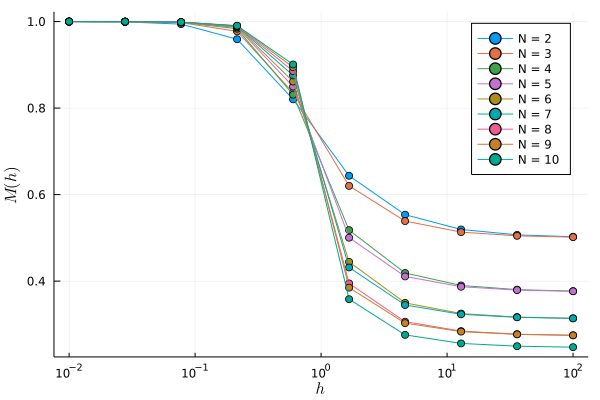

In [14]:
using Plots

function makemagplot()
    p = plot()

    hrange = 10 .^ range(-2., stop=2., length=10)

    for N in 2:10
        M = zeros(length(hrange))
        basis = makebasis(N)

        for (i, h) in enumerate(hrange)
            # diagonalize
            H = isingfield(N=N, h=h)
            vals, vecs = eigen(H)

            # groundstate magnetization
            groundstate = vecs[:, 1]
            M[i] = magnetization(basis, groundstate)
        end

        plot!(
            p, hrange, M, xscale=:log10, marker=:circle,
            label="N = $N",
            xlab=L"h",
            ylab=L"M(h)"
        )
    end
    
    p
end

@time makemagplot()

## Sparsity

The issue with the above implementation is that the Hamiltonian scales with $2^{2N}$, which can quickly cause memory issues.

However, most of the entries of the Hamiltonian will be zero entries. We can instead use a more memory efficient array implementation with `SparseArrays`:

In [15]:
using SparseArrays

isingfield(N=4, h=1) |> sparse

16×16 SparseMatrixCSC{Int64, Int64} with 80 stored entries:
⢟⣵⠑⢄⠑⢄⠀⠀
⠑⢄⢟⣵⠀⠀⠑⢄
⠑⢄⠀⠀⢟⣵⠑⢄
⠀⠀⠑⢄⠑⢄⢟⣵

We'll now reimplement our `isingfield` function to use these `SparseArrays`:

In [16]:
function isingfield(; N::Int, h)
    σᶻ = [1 0; 0 -1] |> sparse
    σˣ = [0 1; 1 0] |> sparse
    
    # add identity
    id = sparse(1 * I, 2, 2)
    
    # assemble terms
    terms = fill(id, N)
    terms[1] = σᶻ
    terms[2] = σᶻ
    
    # sparse H
    H = spzeros(Int, 2^N, 2^N)
    
    # compute first sum
    for i in 1:N-1
        H -= foldl(⊗, terms)
        terms = circshift(terms, 1)
    end
    
    # sum two terms
    terms = fill!(terms, id)
    terms[1] = σˣ
    
    # compute second sum
    for i in 1:N
        H -= h * foldl(⊗, terms)
        terms = circshift(terms, 1)
    end
    
    H
end

@time isingfield(N=10, h=1)

  0.000637 seconds (673 allocations: 2.618 MiB)


1024×1024 SparseMatrixCSC{Int64, Int64} with 11264 stored entries:
⣿⣿⣾⢦⡀⠳⣄⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠺⣟⢻⣶⣿⡂⠈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢤⡈⠻⠻⠿⣧⣤⣠⡈⠳⠄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠙⢦⡀⠀⣻⣿⣿⣙⣦⡀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠙⢦⡈⠳⣼⣿⣿⡆⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠙⢦⡀⠀⠀⠁⠀⠈⠈⠉⣿⣿⣾⢦⡀⠳⣄⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠺⣟⢻⣶⣿⡂⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⢤⡈⠻⠻⠿⣧⣤⣠⡈⠳⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡀⠀⣻⣿⣿⣙⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡈⠳⣼⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄
⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⡟⢦⡈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣍⣿⣿⣯⠀⠈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢦⡈⠋⠛⢻⣶⣦⣦⡈⠓⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠨⣿⠿⣧⣽⡦⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠙⢦⠈⠳⡿⣿⣿⣀⡀⡀⠀⢀⠀⠀⠈⠳⣄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠸⣿⣿⡟⢦⡈⠳⣄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠈⠻⣍⣿⣿⣯⠀⠈⠳⣄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠐⢦⡈⠋⠛⢻⣶⣦⣦⡈⠓
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡀⠨⣿⠿⣧⣽⡦
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠙⢦⠈⠳⡿⣿⣿

Which is incredibly fast and memory efficient. This allows us to compute much larger Hamiltonians:

In [17]:
@time isingfield(N=20, h=1)

  2.219281 seconds (3.77 k allocations: 6.742 GiB, 21.26% gc time)


1048576×1048576 SparseMatrixCSC{Int64, Int64} with 22020096 stored entries:
⣿⣿⣾⢦⡀⠳⣄⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠺⣟⢻⣶⣿⡂⠈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢤⡈⠻⠻⠿⣧⣤⣠⡈⠳⠄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠙⢦⡀⠀⣻⣿⣿⣙⣦⡀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠙⢦⡈⠳⣼⣿⣿⡆⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠙⢦⡀⠀⠀⠁⠀⠈⠈⠉⣿⣿⣾⢦⡀⠳⣄⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠺⣟⢻⣶⣿⡂⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⢤⡈⠻⠻⠿⣧⣤⣠⡈⠳⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡀⠀⣻⣿⣿⣙⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡈⠳⣼⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄
⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⡟⢦⡈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣍⣿⣿⣯⠀⠈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢦⡈⠋⠛⢻⣶⣦⣦⡈⠓⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠨⣿⠿⣧⣽⡦⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠙⢦⠈⠳⡿⣿⣿⣀⡀⡀⠀⢀⠀⠀⠈⠳⣄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠸⣿⣿⡟⢦⡈⠳⣄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠈⠻⣍⣿⣿⣯⠀⠈⠳⣄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠐⢦⡈⠋⠛⢻⣶⣦⣦⡈⠓
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡀⠨⣿⠿⣧⣽⡦
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠙⢦⠈⠳⡿⣿⣿

### Diagonalization of sparse matrices

The regular `eigen` function does not support `SparseMatrix` types. The Julia warning suggests use of [`Arpack.jl`](https://github.com/JuliaLinearAlgebra/Arpack.jl), a wrapper for [Fortran's ARPACK](https://www.caam.rice.edu/software/ARPACK/). However, there also exist pure Julia implementations, such as [`ArnoldiMethod.jl`](https://github.com/haampie/ArnoldiMethod.jl)

In [18]:
using ArnoldiMethod
import LinearAlgebra: eigen

function eigen(x::SparseMatrixCSC)
    decomp, history = partialschur(x, nev=1, which=SR()) # only solve ground state
    vals, vecs = partialeigen(decomp)
    (vals=vals, vecs=vecs)
end

eigen(isingfield(N=10, h=1))

(vals = [-12.381489999654747], vecs = [0.2933991129750299; 0.14835657714581163; … ; 0.14835657691347928; 0.2933991125796642])

Now we have the same interface for our functions, and can recreate our plot from above using a much more efficient implementation:

  0.123960 seconds (64.21 k allocations: 64.731 MiB, 71.46% gc time)


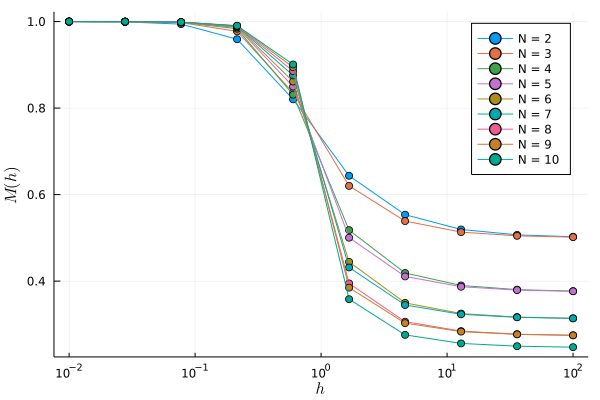

In [20]:
@time makemagplot()

### Sparse magnetization
We'll adapt our `magnetizaion` function to calculate the basis states of $\mathscr{H}$ as `BitVectors` dynamically:

In [24]:
function magnetization(state)
    slength = length(state)
    N = Int(log2(slength))
    M = 0.
    
    for i in 1:slength
        bstate = binrep(i-1, N)
        
        bM = mapreduce(
            spin -> (state[i]^2 * (spin ? 1 : -1)) / N, # mult by spin for orientation
            +, 
            bstate,
            init=0.
        )
        
        @assert abs(bM) <= 1
        M += abs(bM)
    end
    
    M
end

magnetization (generic function with 2 methods)

And then create a new implementation of `makemagplot` to use this alternative function:

 83.496897 seconds (70.07 M allocations: 149.035 GiB, 4.06% gc time)


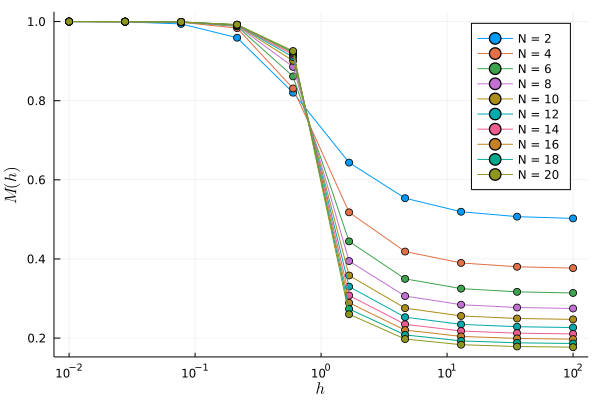

In [30]:
function makemagplot(;nmax=10, nstep=1)
    p = plot()

    hrange = 10 .^ range(-2., stop=2., length=10)

    for N in 2:nstep:nmax
        M = zeros(length(hrange))

        for (i, h) in enumerate(hrange)
            # diagonalize
            H = isingfield(N=N, h=h)
            vals, vecs = eigen(H)

            # groundstate magnetization
            groundstate = @view vecs[:, 1] # no need to copy
            M[i] = magnetization(groundstate)
        end

        plot!(
            p, hrange, M, xscale=:log10, marker=:circle,
            label="N = $N",
            xlab=L"h",
            ylab=L"M(h)"
        )
    end
    
    p
end

@time makemagplot(nmax=20, nstep=2)